# Jigsaw dataset 

In [91]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

import warnings

warnings.filterwarnings('ignore')

PATH = "../data/external/"
PATH_OUTPUT = "../data/inheritim/"
PATH_SAVE_FIGURES = "../reports/figures/"

Firstly, let's check Jigsaw dataset.

In [92]:
train_df = pd.read_csv(os.path.join(PATH, 'jigsaw-train.csv'))
train_df = train_df.drop(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
train_df['non_toxic'] = 1 - train_df['toxic']
train_df.head(10)

,id,comment_text,toxic,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,1


Lets look on the amount of samples of each class in the dataset with histograms.

9.433568719759382


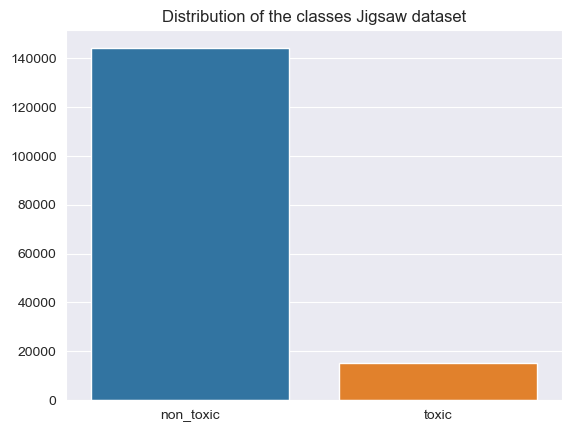

In [120]:
toxic_num = train_df[train_df['toxic'] == 1].shape[0]
nontoxic_num = train_df[train_df['non_toxic'] == 1].shape[0]
sns.barplot(x=['non_toxic', 'toxic'], y=[nontoxic_num, toxic_num])
plt.title("Distribution of the classes Jigsaw dataset")
print(nontoxic_num / toxic_num)
plt.savefig(PATH_SAVE_FIGURES + "class_distribution_jigsaw.png")
plt.show()


As we can see, classes are imbalansed (number of nontoxic comments ~9.5 time greater then number of toxic samples. So, we should deal with it somehow while splitting data into train and test sets to balance classes.

let's check some information about length of the text

In [94]:
train_df["length"] = train_df["comment_text"].str.split().apply(len)
train_df["length"].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: length, dtype: float64

## Wordcloud of the toxic text

In [95]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
words = []

for item in tqdm(train_df[train_df["toxic"] == 1].iterrows()):
    deleted_punctuation = item[1]["comment_text"].translate(str.maketrans('', '', string.punctuation))
    lowercase = deleted_punctuation.lower()
    tokens = lowercase.split()
    deleted_stopwords = [x for x in tokens if x not in stopwords and not x.isdigit()]
    words.extend(deleted_stopwords)

15294it [00:01, 10665.26it/s]


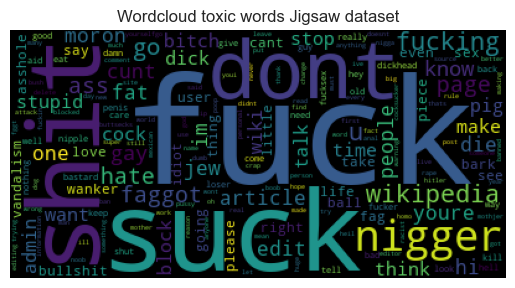

In [97]:
wordcloud = WordCloud(collocations=False).generate(" ".join(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud toxic words Jigsaw dataset")
plt.savefig(PATH_SAVE_FIGURES + "toxic_wordcloud_jigsaw.png")
plt.show()

## Save our dataset

In [98]:
train_df.to_csv(PATH_OUTPUT + "jigsaw.csv")

# ParaNMT-detox dataset

In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

PATH_INPUT = "../data/raw/"
PATH_OUTPUT = "../data/inheritim/"

In [100]:
df = pd.read_table(PATH_INPUT + 'filtered.tsv', index_col=0)
df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


In [101]:
print("Dataset size:", df.shape)
print("Columns:", df.columns.tolist())

Dataset size: (577777, 6)
Columns: ['reference', 'translation', 'similarity', 'lenght_diff', 'ref_tox', 'trn_tox']


In [102]:
df["avg_word_ref"] = df["reference"].str.split().str.len()
df["avg_word_trans"] = df["translation"].str.split().str.len()

# Reference column analysis

In [103]:
print("Unique sentences:", df["reference"].unique().shape)

Unique sentences: (527312,)


Base information about word number of the sentence in 'reference' column.

count    577777.000000
mean         10.283424
std           7.066693
min           1.000000
25%           6.000000
50%           8.000000
75%          13.000000
max         253.000000
Name: avg_word_ref, dtype: float64


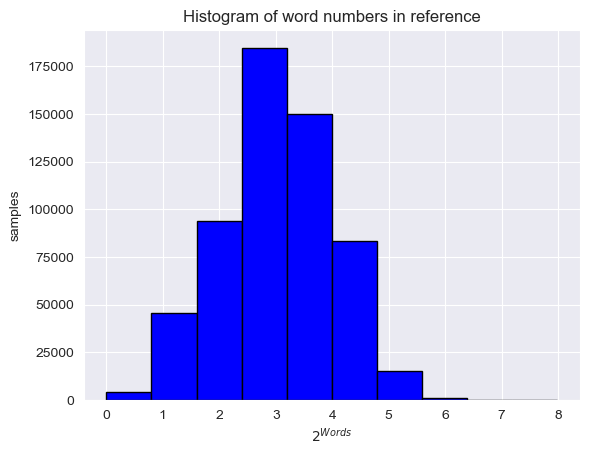

In [104]:
print("Base information about word number of the sentence in 'reference' column.", end="\n\n")
print(df["avg_word_ref"].describe())

_ = plt.hist(np.log2(df["avg_word_ref"]), color = 'blue', edgecolor = 'black')
plt.title('Histogram of word numbers in reference')
plt.xlabel('$2^{Words}$')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "word_numbers_in_reference_paranmt.png")
plt.show()

Base information about toxicity level of reference , etc. 'ref_tox' column.

count    577777.000000
mean          0.541372
std           0.457571
min           0.000033
25%           0.012171
50%           0.806795
75%           0.990469
max           0.999724
Name: ref_tox, dtype: float64


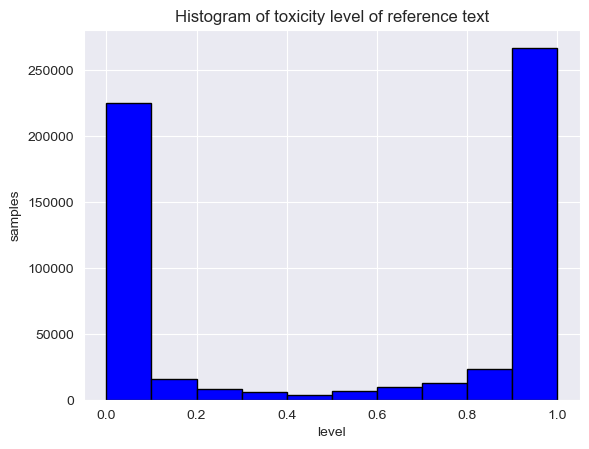

In [105]:
print("Base information about toxicity level of reference , etc. 'ref_tox' column.", end="\n\n")
print(df["ref_tox"].describe())

_ = plt.hist(df["ref_tox"], color = 'blue', edgecolor = 'black')
plt.title('Histogram of toxicity level of reference text')
plt.xlabel('level')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "toxicity_level_reference_text_paranmt.png")
plt.show()

## Reference toxicity level problem

In [106]:
df[df.ref_tox < df.trn_tox].shape

(258635, 8)

As we can see, in reference column we have level toxicity higher than translated, which is not good for our "Detoxification" task. So we need to swap this value.

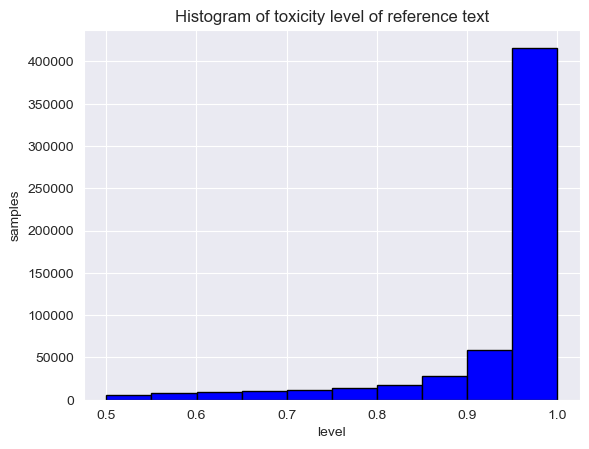

(0, 8)


In [107]:
df['ref_tox'], df['trn_tox'] = np.where(df.ref_tox > df.trn_tox, (df['ref_tox'], df['trn_tox']), (df['trn_tox'], df['ref_tox']))

_ = plt.hist(df["ref_tox"], color = 'blue', edgecolor = 'black')
plt.title('Histogram of toxicity level of reference text')
plt.xlabel('level')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "final_toxicity_level_reference_text_paranmt.png")
plt.show()


print(df[df.ref_tox < df.trn_tox].shape)

Now it's looks like better! :)

## WordCloud of toxic words

Let's see most popular words in toxic sentences.

In [108]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [109]:
words = []

for item in tqdm(df.iterrows()):
    deleted_punctuation = item[1]["reference"].translate(str.maketrans('', '', string.punctuation))
    lowercase = deleted_punctuation.lower()
    tokens = lowercase.split()
    deleted_stopwords = [x for x in tokens if x not in stopwords and not x.isdigit()]
    words.extend(deleted_stopwords)

577777it [00:22, 25483.19it/s]


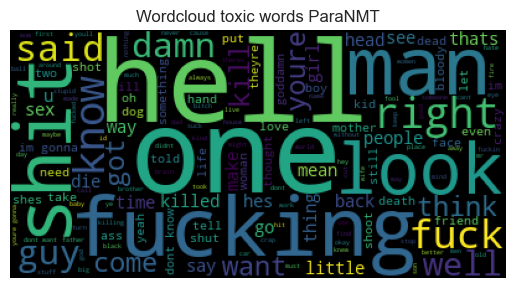

In [110]:
wordcloud = WordCloud().generate(" ".join(words))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud toxic words ParaNMT")
plt.savefig(PATH_SAVE_FIGURES + "toxic_wordcloud_paranmt.png")
plt.show()

## Number of paraphrased per 'reference'

In [111]:
para = df.reference.value_counts()
para.head()

reference
Get off me!                     163
What the hell?                  157
What the hell are you doing?    138
Get off of me!                  104
What the fuck?                  100
Name: count, dtype: int64

In [112]:
print("Number of unique references with > 1 para:", para[para > 1].shape)
print("Number of unique references with == 1 para:", para[para == 1].shape)

Number of unique references with > 1 para: (33673,)
Number of unique references with == 1 para: (493639,)


As we can see, there are several references, which has more than 1 translation. Let's see the AVG number of translation per reference with > 1 para.

In [113]:
para[para > 1].mean()

2.4986784664271076

# Translation column analysis

In [114]:
print("Unique sentences:", df["translation"].unique().shape)

Unique sentences: (478156,)


Base information about word number of the sentence in 'translation' column.

count    577777.000000
mean          9.680460
std           6.900881
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max         179.000000
Name: avg_word_trans, dtype: float64


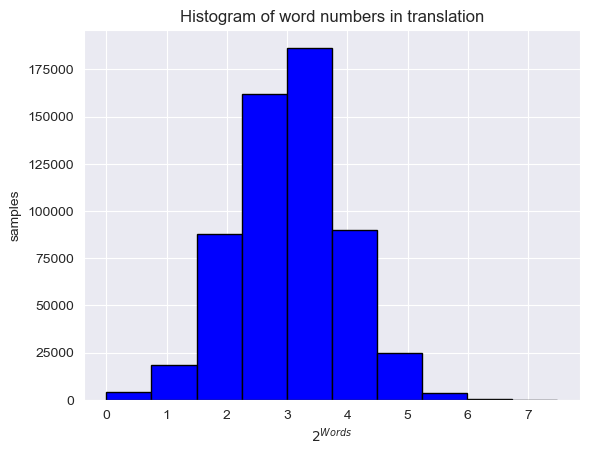

In [115]:
print(f"Base information about word number of the sentence in 'translation' column.", end="\n\n")
print(df["avg_word_trans"].describe())

_ = plt.hist(np.log2(df["avg_word_trans"]), color = 'blue', edgecolor = 'black')
plt.title('Histogram of word numbers in translation')
plt.xlabel('$2^{Words}$')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "word_numbers_in_translation_paranmt.png")
plt.show()

Base information about toxicity level of translation text, etc. 'trn_tox' column.

count    577777.000000
mean          0.940260
std           0.100831
min           0.500139
25%           0.940145
50%           0.983842
75%           0.997519
max           0.999730
Name: ref_tox, dtype: float64


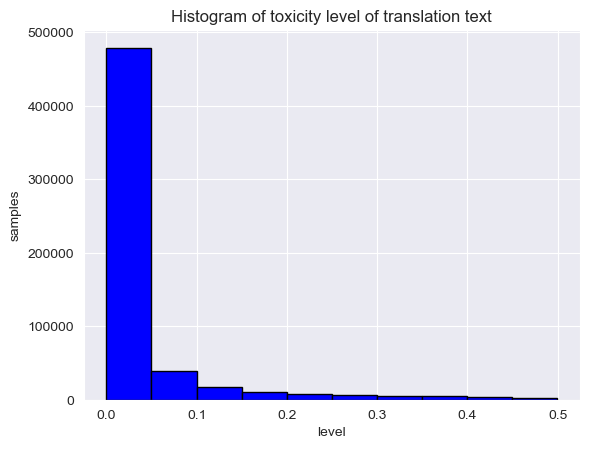

In [116]:
print("Base information about toxicity level of translation text, etc. 'trn_tox' column.", end="\n\n")
print(df["ref_tox"].describe())

_ = plt.hist(df["trn_tox"], color = 'blue', edgecolor = 'black')
plt.title('Histogram of toxicity level of translation text')
plt.xlabel('level')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "toxicity_level_translation_text_paranmt.png")
plt.show()

# Similarity column analysis

Base information about similarity level between reference and translation columns.

count    577777.000000
mean          0.758469
std           0.092695
min           0.600001
25%           0.681105
50%           0.754439
75%           0.831244
max           0.950000
Name: similarity, dtype: float64


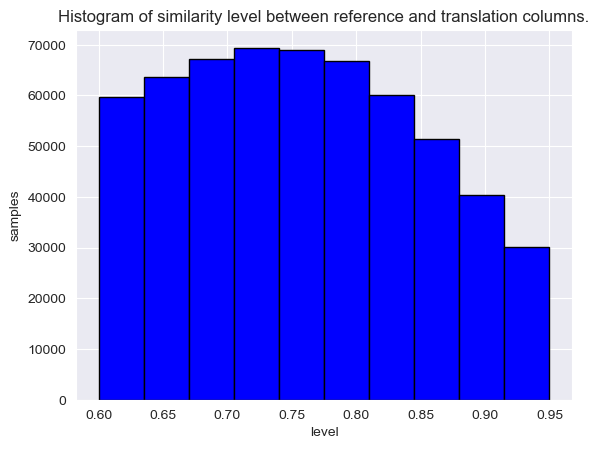

In [117]:
print("Base information about similarity level between reference and translation columns.", end="\n\n")
print(df["similarity"].describe())

_ = plt.hist(df["similarity"], color = 'blue', edgecolor = 'black')
plt.title('Histogram of similarity level between reference and translation columns.')
plt.xlabel('level')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "similarity_level_paranmt.png")
plt.show()

Here we can see, that they are pretty similar (> 0.6).

# Length difference column analysis

Base information about length difference number between reference and translation columns.

count    577777.000000
mean          0.157652
std           0.108057
min           0.000000
25%           0.066667
50%           0.141791
75%           0.238095
max           0.400000
Name: lenght_diff, dtype: float64


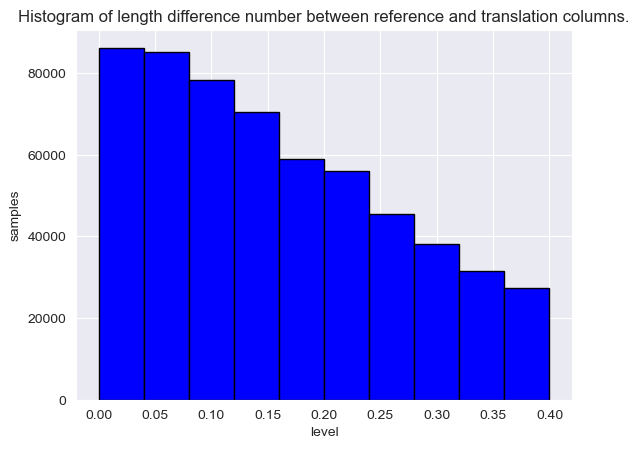

In [118]:
print("Base information about length difference number between reference and translation columns.", end="\n\n")
print(df["lenght_diff"].describe())

_ = plt.hist(df["lenght_diff"], color = 'blue', edgecolor = 'black')
plt.title('Histogram of length difference number between reference and translation columns.')
plt.xlabel('level')
plt.ylabel('samples')
plt.savefig(PATH_SAVE_FIGURES + "length_difference_paranmt.png")
plt.show()


Range of difference might be from 0% to 40% by symbols.

# Save our dataset

In [119]:
df.to_csv(PATH_OUTPUT + "filtered.csv")